# Problem Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

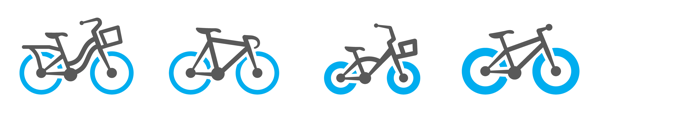

# Data Overview

You are provided hourly rental data spanning two years. 
For this competition, **the training set is comprised of the first 19 days of each month**, while the **test set is the 20th to the end of the month.** 

You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

## Data Fields

- datetime - hourly date + timestamp  
- season - 
         1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
          1: Clear, Few clouds, Partly cloudy, Partly cloudy
          2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

# Importing libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [10]:
pip install missingno

In [25]:
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Exploring the Data

In [3]:
train = pd.read_csv("kaggle_bike_sharing_train.csv")
test = pd.read_csv("kaggle_bike_sharing_test.csv")

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In the first column of training data we cannot access the date and time just like that so, it is better to store their values as seperate column in the table, which will make it easier to analyze and make predictions

In [6]:
train_date = pd.DatetimeIndex(train['datetime'])
train['year'] = train_date.year
train['month'] = train_date.month
train['hour'] = train_date.hour
train['dayofweek'] = train_date.dayofweek

In [31]:
test_date = pd.DatetimeIndex(test['datetime'])
test['year'] = test_date.year
test['month'] = test_date.month
test['hour'] = test_date.hour
test['dayofweek'] = test_date.dayofweek

In [7]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


## Missing Values

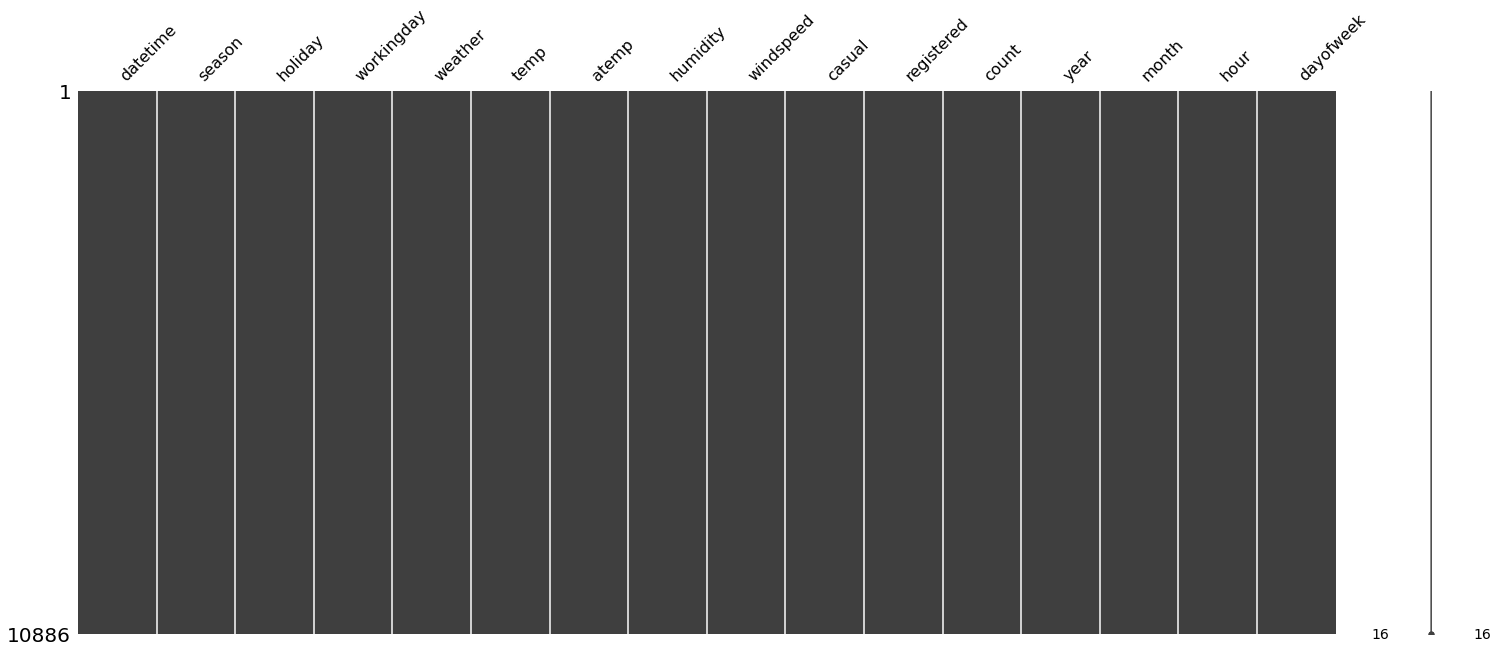

In [14]:
msno.matrix(train)

Thus our training data has 10,886 samples but no missing values. One less thing to worry about

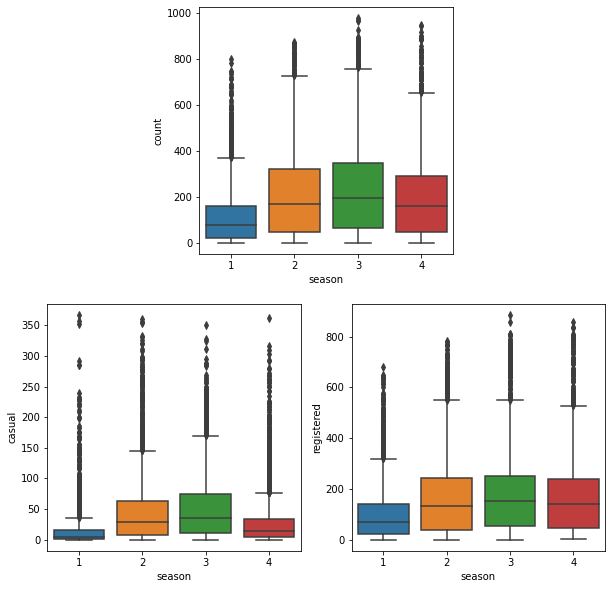

In [15]:
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='season', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='season', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='season', y='registered', data=train)
plt.show()

- The demand for bike rentals is less in winter than in summer maybe because people prefer closed vehicles during winter to protect themselves from cold winds.
- This point is bolstered by the fact that ver small number of new users start using bike rentals during winter. 


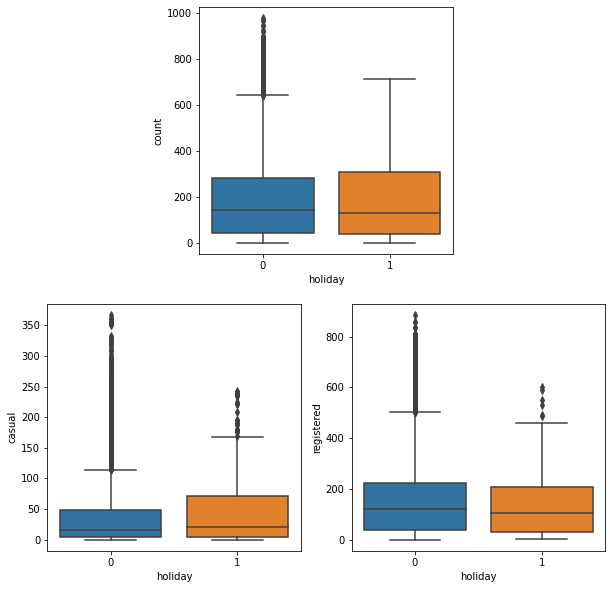

In [16]:
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='holiday', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='holiday', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='holiday', y='registered', data=train)
plt.show()

This boxplot does not provide us some insights

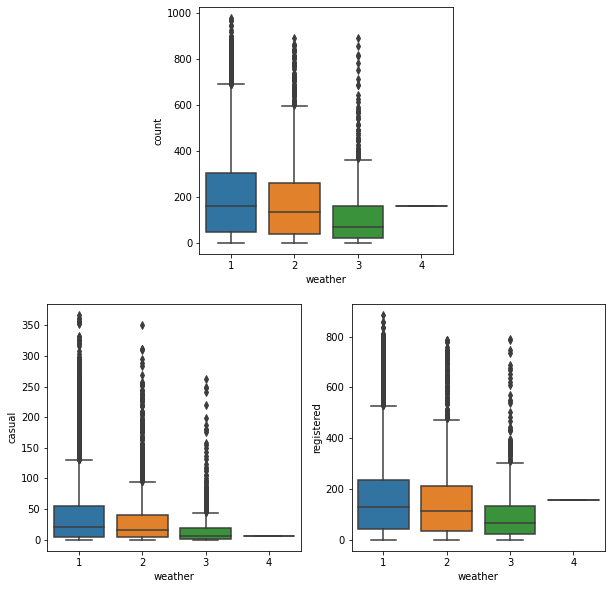

In [17]:
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='weather', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='weather', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='weather', y='registered', data=train)
plt.show()

This boxplot perfectly sums up the argument that as the outside weather deteriorates that is it slips from nice cool breeze to thunderstorms, the demand of bike rentals drop. 

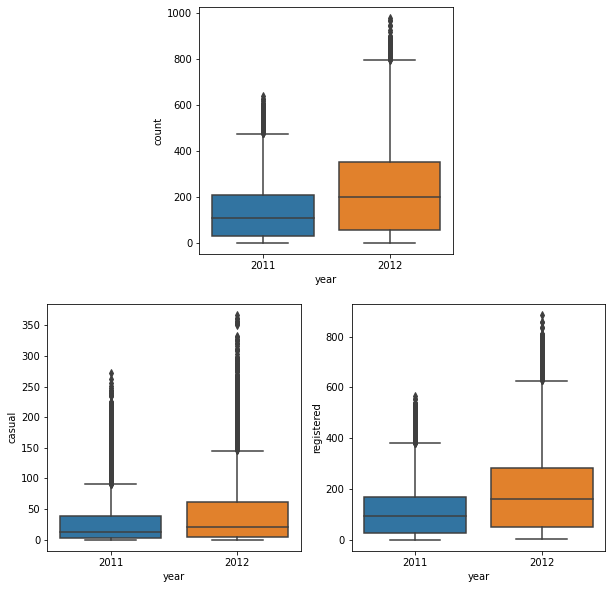

In [18]:
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='year', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='year', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='year', y='registered', data=train)
plt.show()

The demand of bike rentals went significanlty up, from 2011 to 2012, this might have something to do with the increase in popularity as more new customers join in to avail the service.

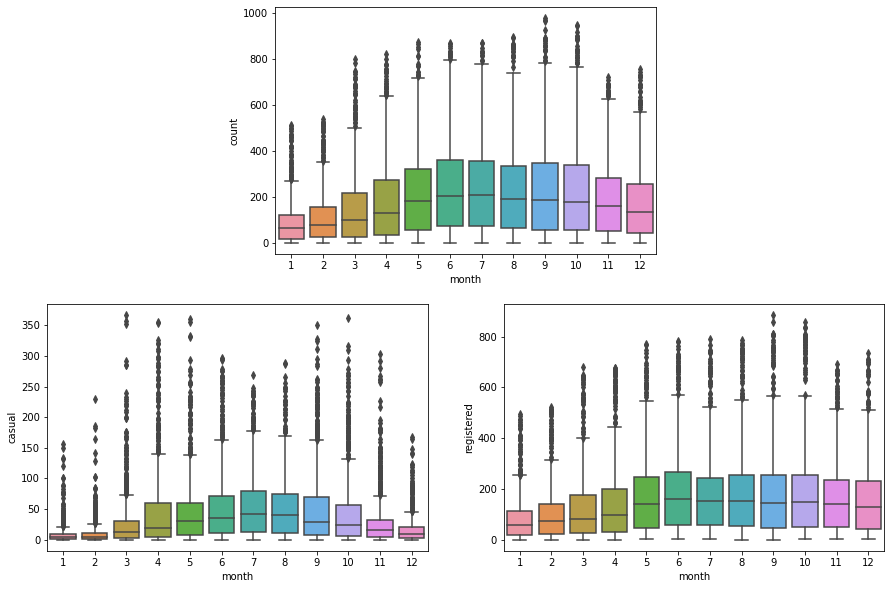

In [19]:
fig = plt.figure(figsize=(15, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='month', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='month', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='month', y='registered', data=train)
plt.show()

This boxplot shows us that in the middle of the year, the demand is the maximum because of the normal weather, except compared to the extreme months like Januray and December, where there is a low temperature

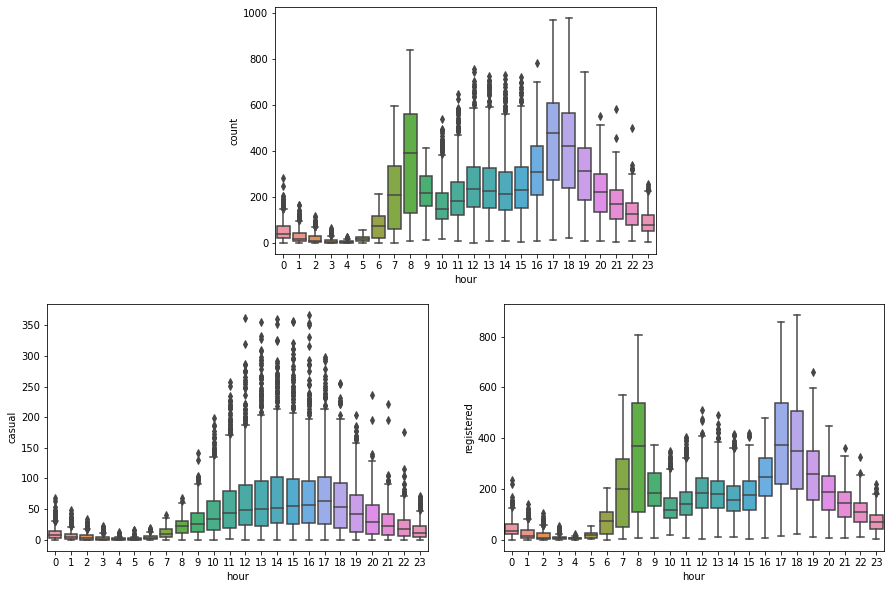

In [20]:
fig = plt.figure(figsize=(15, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='hour', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='hour', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='hour', y='registered', data=train)
plt.show()

This graph has peak around 7-8 am and then from 5-6 pm, this is exactly the time at which people go to the office and come back from work. This trend is perfectly visible in the registrerd user section, as they must have registered for the bike rentals to go to their offices.

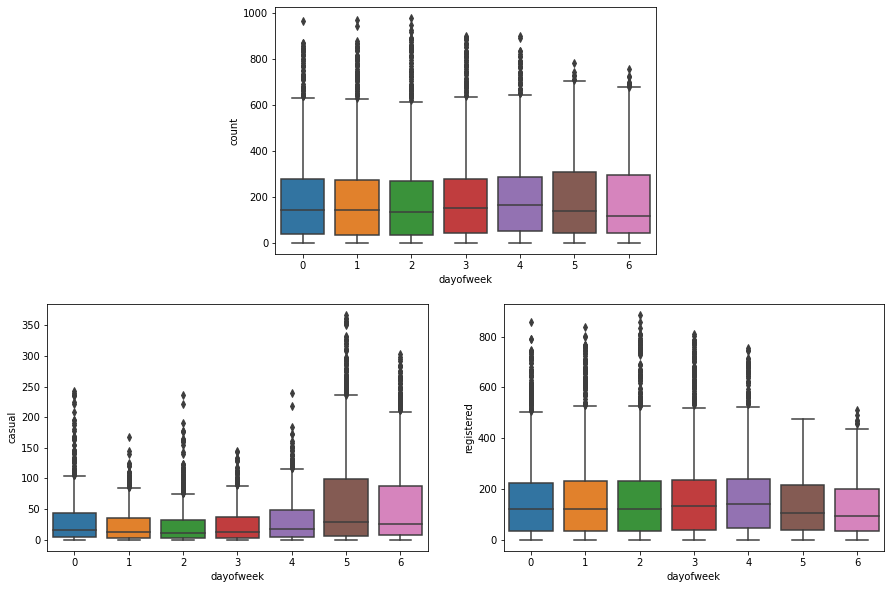

In [21]:
fig = plt.figure(figsize=(15, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='dayofweek', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='dayofweek', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='dayofweek', y='registered', data=train)
plt.show()

Casual people are more likely to take the bike rentals during the weekends, on the other hand the registered user take the bike more commonly during the work days, as they may have reistered for bike rentals so that they can reach their offices.

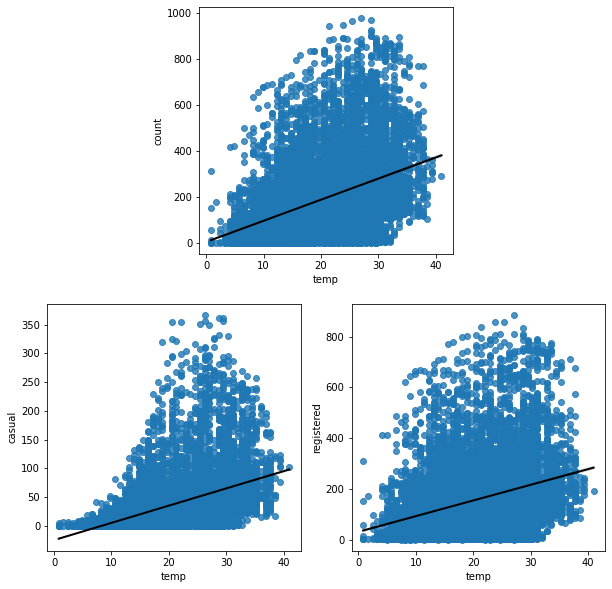

In [22]:
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.regplot(x='temp', y='count', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.subplot(gs1[2:, :2])
sns.regplot(x='temp', y='casual', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.subplot(gs1[2:, 2:])
sns.regplot(x='temp', y='registered', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.show()

So, as the temperature increases the number of bike rentals increases as a trend

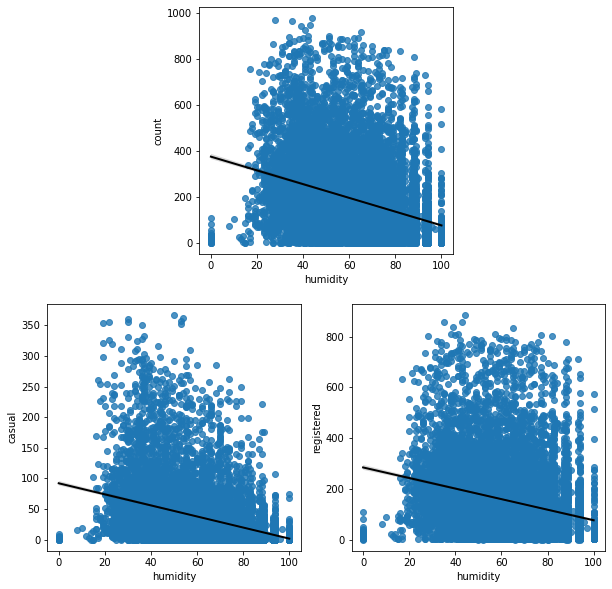

In [23]:
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.regplot(x='humidity', y='count', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.subplot(gs1[2:, :2])
sns.regplot(x='humidity', y='casual', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.subplot(gs1[2:, 2:])
sns.regplot(x='humidity', y='registered', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.show()

Also, higher humidity means less demand of bike rentals

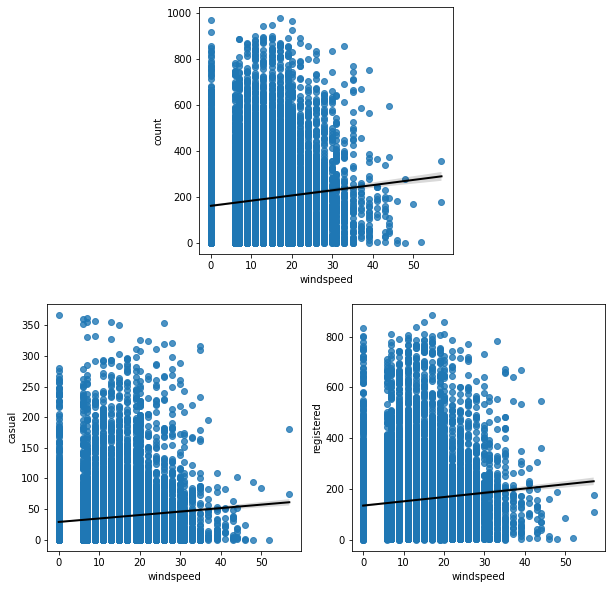

In [24]:
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.regplot(x='windspeed', y='count', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.subplot(gs1[2:, :2])
sns.regplot(x='windspeed', y='casual', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.subplot(gs1[2:, 2:])
sns.regplot(x='windspeed', y='registered', data=train,
            line_kws={"color":"black", "linewidth":2})
plt.show()

As expected, as the wind speed increases, the demand for bike rentals decreases. The same trend is observed in both casual and registered users.

# Checking Distplots of Casual and Registered Users

This is done so as to check the shape of their distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



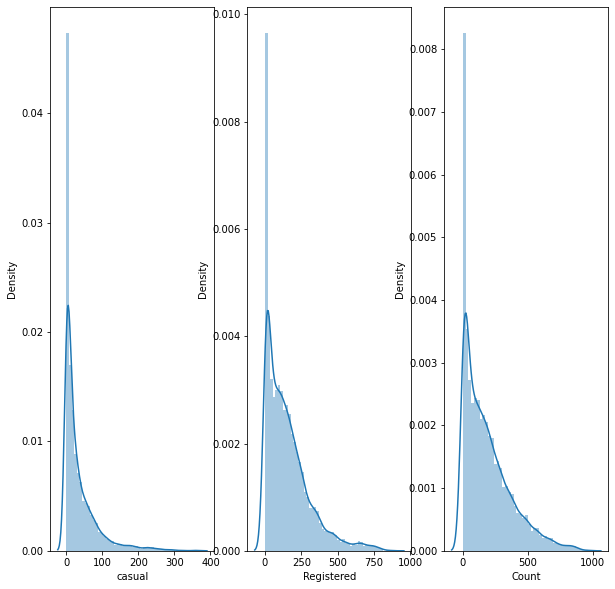

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(131)
sns.distplot(train['casual'])
plt.xlabel("casual")
plt.subplot(132)
sns.distplot(train['registered'])
plt.xlabel("Registered")
plt.subplot(133)
sns.distplot(train['count'])
plt.xlabel("Count")
plt.show()

Now, these distibutions are not normal so we need to perform transformation on them to make them more normal.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in arcsin

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simila

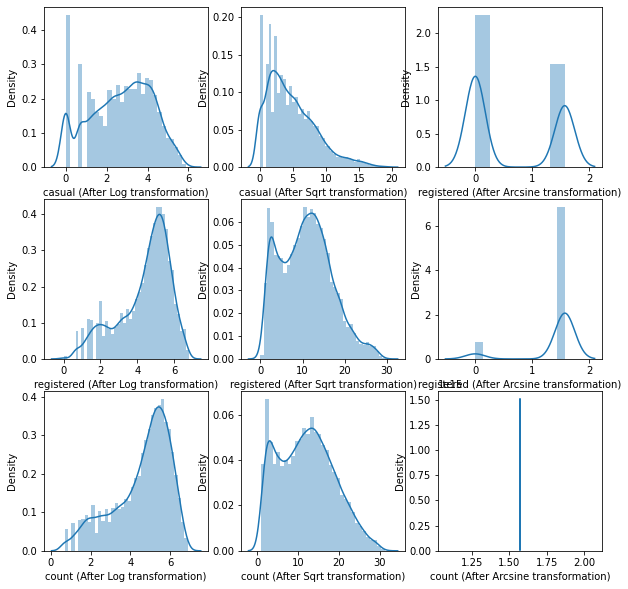

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(331)
sns.distplot(np.log(train['casual']+1))
plt.xlabel("casual (After Log transformation)")
plt.subplot(332)
sns.distplot(np.sqrt(train['casual']))
plt.xlabel("casual (After Sqrt transformation)")
plt.subplot(333)
sns.distplot(np.arcsin(train['casual']))
plt.xlabel("registered (After Arcsine transformation)")

plt.subplot(334)
sns.distplot(np.log(train['registered']+1))
plt.xlabel("registered (After Log transformation)")
plt.subplot(335)
sns.distplot(np.sqrt(train['registered']))
plt.xlabel("registered (After Sqrt transformation)")
plt.subplot(336)
sns.distplot(np.arcsin(train['registered']))
plt.xlabel("registered (After Arcsine transformation)")

plt.subplot(337)
sns.distplot(np.log(train['count']+1))
plt.xlabel("count (After Log transformation)")
plt.subplot(338)
sns.distplot(np.sqrt(train['count']))
plt.xlabel("count (After Sqrt transformation)")
plt.subplot(339)
sns.distplot(np.arcsin(train['count']))
plt.xlabel("count (After Arcsine transformation)")

plt.show()



Out of all these transformations, log transformation works the best so we will use that. 
Therefore, we add another column for log values corresponding to the casual, registered and the count column.

In [29]:
for col in ['casual', 'registered', 'count']:
    train['%s_log' % col] = np.log(train[col] + 1)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek,casual_log,registered_log,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5,1.386294,2.639057,2.833213
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,2.197225,3.496508,3.713572
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5,1.791759,3.332205,3.496508
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5,1.386294,2.397895,2.639057
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5,0.000000,0.693147,0.693147


## Adding New Features

In [32]:
for df in [train, test]:
    df['year_season'] = df['year'] + df['season'] / 10
    df['hour_workingday_casual'] = df[['hour', 'workingday']].apply(
        lambda x: int(10 <= x['hour'] <= 19), axis=1)
    df['hour_workingday_registered'] = df[['hour', 'workingday']].apply(
      lambda x: int(
        (x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18))
        or (x['workingday'] == 0 and 10 <= x['hour'] <= 19)), axis=1)

by_season = train.groupby('year_season')[['count']].median()
by_season.columns = ['count_season']
train = train.join(by_season, on='year_season')
test = test.join(by_season, on='year_season')

In [34]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek,casual_log,registered_log,count_log,year_season,hour_workingday_casual,hour_workingday_registered,count_season
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5,1.386294,2.639057,2.833213,2011.1,0,0,57
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,2.197225,3.496508,3.713572,2011.1,0,0,57
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5,1.791759,3.332205,3.496508,2011.1,0,0,57
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5,1.386294,2.397895,2.639057,2011.1,0,0,57
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5,0.000000,0.693147,0.693147,2011.1,0,0,57


In [ ]:
train.iloc[1350]

# Fitting Gradient Boosting Regressor Model

We will only select some features for our  model.


In [54]:
# Prediction for Casual Demand
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour','month', 'dayofweek', 'hour_workingday_casual', 'count_season']
reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
reg.fit(train[features], train['casual_log'])
pred_casual = reg.predict(test[features])
pred_casual = np.exp(pred_casual) - 1
pred_casual[pred_casual < 0] = 0

#Perdiction for Registration Demand
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour', 'month', 'dayofweek', 'hour_workingday_registered', 'count_season']
reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
reg.fit(train[features], train['registered_log'])
pred_registered = reg.predict(test[features])
pred_registered = np.exp(pred_registered) - 1
pred_registered[pred_registered < 0] = 0

pred1 = pred_casual + pred_registered

## Checking our Predictions

In [58]:
test = test.drop('Predicted Demand', 1)
test = test.drop('Predicted_Demand',1)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek,year_season,hour_workingday_casual,hour_workingday_registered,count_season
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3,2011.1,0,0,57
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3,2011.1,0,0,57
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3,2011.1,0,0,57
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3,2011.1,0,0,57
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3,2011.1,0,0,57


In [59]:
pred_test = test
pred_test['Predicted_Demand'] = pred1

pred_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek,year_season,hour_workingday_casual,hour_workingday_registered,count_season,Predicted_Demand
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3,2011.1,0,0,57,8.808039
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3,2011.1,0,0,57,4.122591
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3,2011.1,0,0,57,2.513046
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3,2011.1,0,0,57,1.653959
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3,2011.1,0,0,57,1.441062


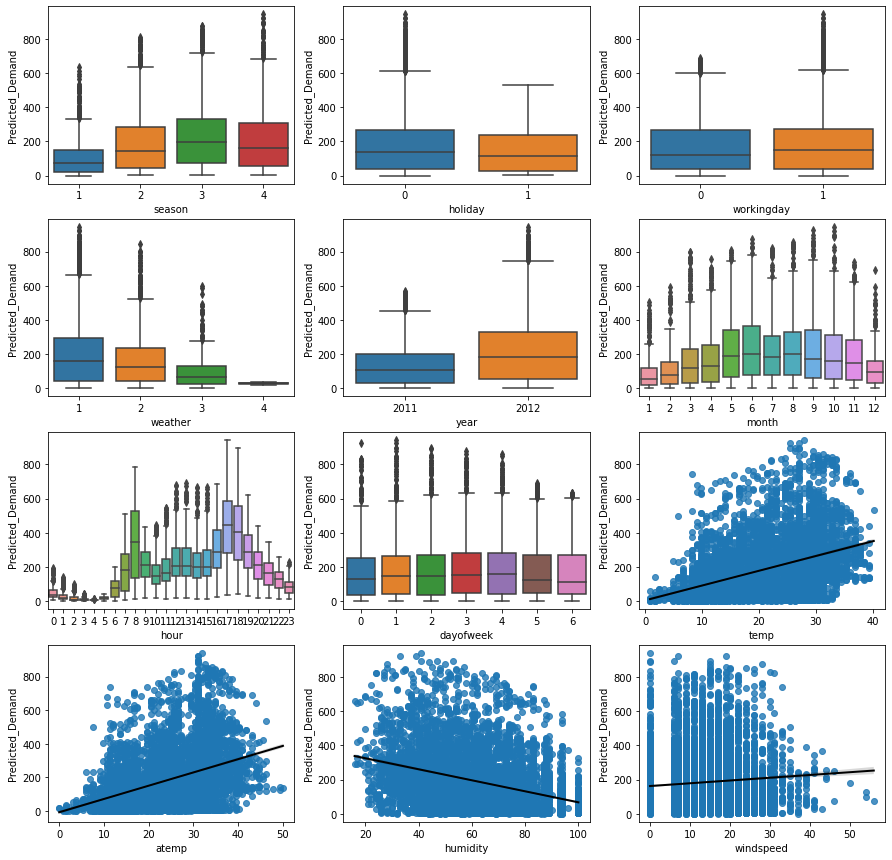

In [60]:
plt.figure(figsize=(15, 15))

plt.subplot(431)
sns.boxplot(x='season', y='Predicted_Demand', data=pred_test)

plt.subplot(432)
sns.boxplot(x='holiday', y='Predicted_Demand', data=pred_test)

plt.subplot(433)
sns.boxplot(x='workingday', y='Predicted_Demand', data=pred_test)

plt.subplot(434)
sns.boxplot(x='weather', y='Predicted_Demand', data=pred_test)

plt.subplot(435)
sns.boxplot(x='year', y='Predicted_Demand', data=pred_test)

plt.subplot(436)
sns.boxplot(x='month', y='Predicted_Demand', data=pred_test)

plt.subplot(437)
sns.boxplot(x='hour', y='Predicted_Demand', data=pred_test)

plt.subplot(438)
sns.boxplot(x='dayofweek', y='Predicted_Demand', data=pred_test)

plt.subplot(439)
sns.regplot(x='temp', y='Predicted_Demand', data=pred_test,
            line_kws={"color":"black", "linewidth":2})

plt.subplot(4,3,10)
sns.regplot(x='atemp', y='Predicted_Demand', data=pred_test,
            line_kws={"color":"black", "linewidth":2})

plt.subplot(4,3,11)
sns.regplot(x='humidity', y='Predicted_Demand', data=pred_test,
            line_kws={"color":"black", "linewidth":2})

plt.subplot(4,3,12)
sns.regplot(x='windspeed', y='Predicted_Demand', data=pred_test,
            line_kws={"color":"black", "linewidth":2})


plt.show()



Based on these graph we can conclude that our predictions are alright as all the trends of the training dataset are followed in the testing dataset.
Like there is less demand in the extreme months, the demand decrease with the rise in the windspeed and humidity and also increases with the increase in temperature. And likewise

# Hyper parameter Tuning

Since, we dont know which value of number of estimators and number of leaf size is the best for making predited we need to check for some values to ibserve the optimal solution

### No. of Estimators

{'n_estimators': 1200}


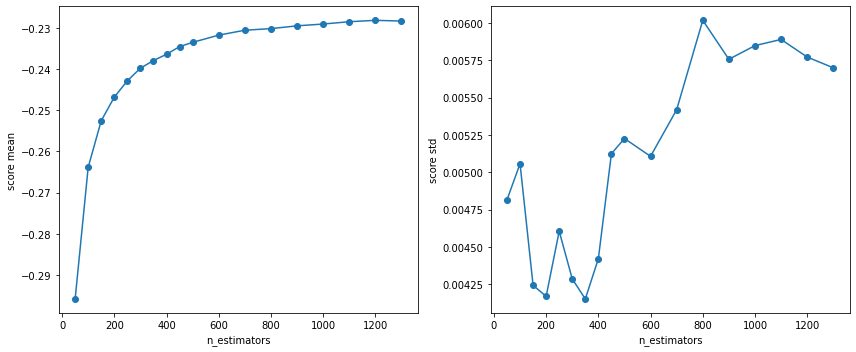

{'n_estimators': 1300}


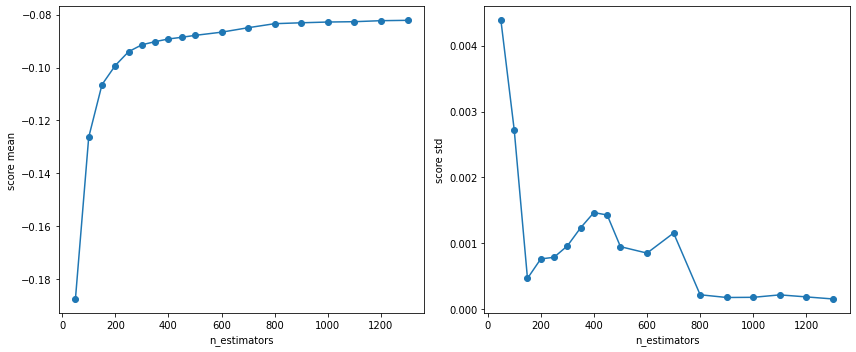

In [63]:
def plot_cv(param, bestreg, variable):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(param[variable], bestreg.cv_results_['mean_test_score'], 'o-')
    plt.xlabel(variable)
    plt.ylabel("score mean")
    plt.subplot(122)
    plt.plot(param[variable], bestreg.cv_results_['std_test_score'], 'o-')
    plt.xlabel(variable)
    plt.ylabel("score std")
    plt.tight_layout()
    plt.show()

year_month = train['year'] * 100 + train['month']
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

reg = GradientBoostingRegressor(random_state=0)
param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000,1100,1200,1300]}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['casual_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "n_estimators")

reg = GradientBoostingRegressor(random_state=0)
param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000,1100,1200,1300]}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['registered_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "n_estimators")

### No. of leafs

{'min_samples_leaf': 6}


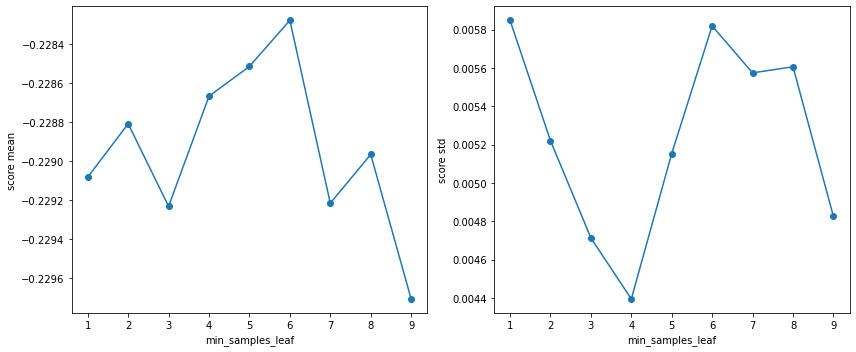

{'min_samples_leaf': 6}


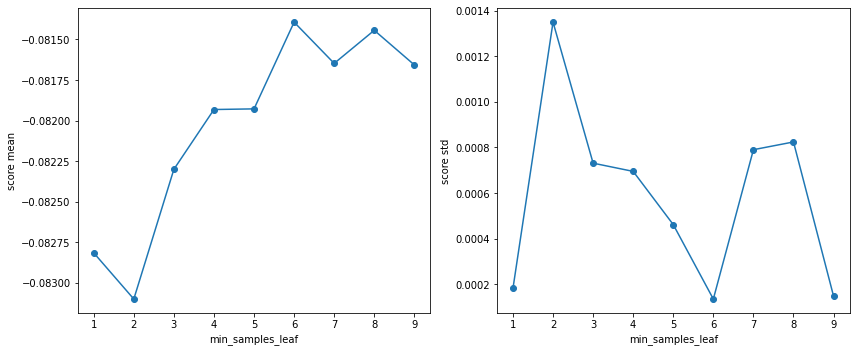

In [66]:
reg = GradientBoostingRegressor(n_estimators=1000, random_state=0)
param = {"min_samples_leaf": np.arange(1, 10, 1)}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['casual_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "min_samples_leaf")

reg = GradientBoostingRegressor(n_estimators=1000, random_state=0)
param = {"min_samples_leaf": np.arange(1, 10, 1)}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['registered_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "min_samples_leaf")

In [65]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek,casual_log,registered_log,count_log,year_season,hour_workingday_casual,hour_workingday_registered,count_season
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5,1.386294,2.639057,2.833213,2011.1,0,0,57
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,2.197225,3.496508,3.713572,2011.1,0,0,57
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5,1.791759,3.332205,3.496508,2011.1,0,0,57
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5,1.386294,2.397895,2.639057,2011.1,0,0,57
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5,0.000000,0.693147,0.693147,2011.1,0,0,57


# Generating csv file for submission

In [62]:
submission = pd.DataFrame({'datetime':test.datetime, 'count':pred1},
                          columns = ['datetime', 'count'])
submission.to_csv("submission_1.csv", index=False)